In [0]:
import os
import csv
import time
import random
from pathlib import Path
from tqdm import tqdm

import numpy as np
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from PIL import ImageEnhance
from partialconv.models.partialconv2d import PartialConv2d
# coding: utf-8

%matplotlib inline

In [0]:
def register_extension(id, extension):
    Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions):
    for extension in extensions:
        register_extension(id, extension)
Image.register_extensions = register_extensions

In [0]:
import requests

def send_image_to_slack(img_path, token, channel, file_name, comment, title):
    files = {'file': open(img_path, 'rb')}
    param = {
        'token': token,
        'channels': channel,
        'filename': file_name,
        'initial_comment': comment,
        'title': title
    }
    requests.post(
        url="https://slack.com/api/files.upload", params=param, files=files)

In [0]:
def get_noise_from_uniform(batch_size=1,
                           input_dim=100,
                           convert_tensor=False,
                           low=-1,
                           high=1):
    noise_z = np.random.uniform(
        low, high, size=[batch_size, input_dim]).astype(np.float32)
    if (convert_tensor):
        noise_z = torch.from_numpy(noise_z)
    return noise_z

In [0]:
class Interpolate(nn.Module):
    def __init__(self, scale_factor, mode):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        #self.size = size
        self.scale_factor = scale_factor
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, scale_factor=2, mode=self.mode, align_corners=False)
        return x

In [0]:
class Generator(nn.Module):
 
    def __init__(self, n_channel):
        super(Generator, self).__init__()
        
        self.n_channel = n_channel
        
        self.fc1 = nn.Linear(100, 96*96*self.n_channel)
        self.fc1_bn = nn.BatchNorm1d(96*96*self.n_channel)
        #self.conv1_down = nn.Conv2d(self.n_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv1_down = PartialConv2d(self.n_channel, 32, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        
        #self.conv2_down = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv2_down = PartialConv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        
        #self.conv3_down = nn.Conv2d(64, 64, kernel_size=3,stride=1,padding=1)
        self.conv3_down = PartialConv2d(64, 64, kernel_size=3,stride=1,padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        
        #self.conv4_down = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4_down = PartialConv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4_bn = nn.BatchNorm2d(128)
        
        #self.conv5_down = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5_down = PartialConv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5_bn = nn.BatchNorm2d(128)
        
        #self.conv6_down = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv6_down = PartialConv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv6_bn = nn.BatchNorm2d(256)
        
        #self.conv7_down = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv7_down = PartialConv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv7_bn = nn.BatchNorm2d(256)
        
        #self.conv8_up = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.conv8_interp = Interpolate(scale_factor=2, mode='bilinear')
        self.conv8_up = PartialConv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.conv8_bn = nn.BatchNorm2d(256)
        
        #self.conv9_up = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.conv9_up = PartialConv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.conv9_bn = nn.BatchNorm2d(128)
        
        #self.conv10_up = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv10_interp = Interpolate(scale_factor=2, mode='bilinear')
        self.conv10_up = PartialConv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.conv10_bn = nn.BatchNorm2d(128)
        
        #self.conv11_up = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv11_up = PartialConv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv11_bn = nn.BatchNorm2d(64)
        
        #self.conv12_up = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv12_interp = Interpolate(scale_factor=2, mode='bilinear')
        self.conv12_up = PartialConv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv12_bn = nn.BatchNorm2d(64)
        
        #self.conv13_up = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv13_up = PartialConv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv13_bn = nn.BatchNorm2d(32)
        
        #self.conv14_up = nn.Conv2d(64, self.n_classes, kernel_size=3, stride=1, padding=1)
        self.conv14_up = PartialConv2d(64, self.n_channel, kernel_size=3, stride=1, padding=1)
        
        self.relu = nn.LeakyReLU(0.2)
        #self.relu = nn.ReLU()
        self.dropout = DropBlock2D(drop_prob=0.1, block_size=3)
 
    def forward(self, x):
        
        x = self.relu(self.fc1_bn(self.fc1(x)))
        x = x.view(-1, self.n_channel, 96, 96)
        ### down
        x1 = self.relu(self.conv1_bn(self.conv1_down(x)))
        del x
        x2 = self.dropout(self.relu(self.conv2_bn(self.conv2_down(x1))))
        x3 = self.dropout(self.relu(self.conv3_bn(self.conv3_down(x2))))
        del x2
        x4 = self.dropout(self.relu(self.conv4_bn(self.conv4_down(x3))))
        x5 = self.dropout(self.relu(self.conv5_bn(self.conv5_down(x4))))
        del x4
        x6 = self.dropout(self.relu(self.conv6_bn(self.conv6_down(x5))))
        x7 = self.dropout(self.relu(self.conv7_bn(self.conv7_down(x6))))
        ### up
        x8 = torch.cat([x7, x6], dim=1)
        del x7,x6
        #x8 = self.dropout(self.relu(self.conv8_bn(self.conv8_up(x8))))
        x8 = self.dropout(self.relu(self.conv8_bn(self.conv8_up(self.conv8_interp(x8)))))
        x9 = self.dropout(self.relu(self.conv9_bn(self.conv9_up(x8))))
        del x8
        
        x10 = torch.cat([x5, x9], dim=1)
        del x5,x9
        
        x10 = self.dropout(self.relu(self.conv10_bn(self.conv10_up(self.conv10_interp(x10)))))
        x11 =  self.dropout(self.relu(self.conv11_bn(self.conv11_up(x10))))
        del x10
        
        x12 = torch.cat([x3, x11], dim=1)
        del x3,x11
        x12 = self.dropout(self.relu(self.conv12_bn(self.conv12_up(self.conv12_interp(x12)))))
        
        x13 = self.dropout(self.relu(self.conv13_bn(self.conv13_up(x12))))
        del x12
        
        x14 = torch.cat([x1, x13], dim=1)
        del x1,x13
        
        x14 = self.conv14_up(x14)
        #x14 = x14.view(-1, self.n_classes, self.patch_width, self.patch_height)
        #x14 = x14.permute((0, 2, 1))
        x14 = torch.sigmoid(x14)

        return x14

In [0]:
class Critic_A(nn.Module):
 
    def __init__(self, n_channel):
        super(Critic_A, self).__init__()
        
        self.n_channel = n_channel
        
        # 64*64
        self.conv1 = PartialConv2d(n_channel, 64, kernel_size=4, stride=2, padding=1)
        self.conv1_bn = nn.BatchNorm2d(64)
        
        # 32*32
        self.conv2 = PartialConv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv2_bn = nn.BatchNorm2d(128)
        
        # 16*16
        self.conv3 = PartialConv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv3_bn = nn.BatchNorm2d(256)        

        # 8*8
        self.conv4 = PartialConv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.conv4_bn = nn.BatchNorm2d(512)   
        
        self.fc1 = nn.Linear(6*6*256, 1)
        self.relu = torch.nn.PReLU()#nn.LeakyReLU(0.2)
        self.drop = DropBlock2D(drop_prob=0.1, block_size=3)
        
    def forward(self, x):
        
        x = self.relu(self.conv1_bn(self.conv1(x)))
        #x = self.drop(self.relu(self.conv2_bn(self.conv2(x))))
        x = self.drop(self.relu(self.conv2_bn(self.conv2(x))))
        x = self.drop(self.relu(self.conv3_bn(self.conv3(x))))
        x = self.drop(self.relu(self.conv4_bn(self.conv4(x))))
        x = x.view(-1, 6*6*256)
        x = self.fc1(x)
        
        return x

In [0]:
class Critic_B(nn.Module):
 
    def __init__(self, n_channel):
        super(Critic_B, self).__init__()
        
        self.n_channel = n_channel
        
        # 64*64
        self.conv1 = PartialConv2d(n_channel, 32, kernel_size=4, stride=2, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        
        # 32*32
        self.conv2 = PartialConv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        
        # 16*16
        self.conv3 = PartialConv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3_bn = nn.BatchNorm2d(128)        
        
        self.fc1 = nn.Linear(12*12*128, 6*6*256)
        self.fc1_bn = nn.BatchNorm1d(6*6*256)
        self.fc2 = nn.Linear(6*6*256, 1)
        self.relu = nn.LeakyReLU(0.2)
        self.drop_1d = nn.Dropout(p=0.2)
        self.drop_2d = nn.Dropout2d (p=0.2)
        
    def forward(self, x):
        
        x = self.relu(self.conv1_bn(self.conv1(x)))
        x = self.drop_2d(self.relu(self.conv2_bn(self.conv2(x))))
        x = self.drop_2d(self.relu(self.conv3_bn(self.conv3(x))))
        x = x.view(-1, 12*12*128)
        x = self.drop_1d(self.relu(self.fc1_bn(self.fc1(x))))
        x = self.fc2(x)
        
        return x

In [0]:
class Critic_C(nn.Module):
 
    def __init__(self, n_channel):
        super(Critic_C, self).__init__()
        
        self.n_channel = n_channel
        
        self.fc1 = nn.Linear(96*96*3, 2048)
        self.fc1_bn = nn.BatchNorm1d(2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc2_bn = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc3_bn = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, 1)
        self.relu = torch.nn.ReLU()
        self.drop = nn.Dropout(p=0.2)
        
    def forward(self, x):
        
        x = x.view(-1, 96*96*3)
        x = self.relu(self.fc1_bn(self.fc1(x)))
        x = self.drop(self.relu(self.fc2_bn(self.fc2(x))))
        x = self.drop(self.relu(self.fc3_bn(self.fc3(x))))
        x = self.fc4(x)
        
        return x

In [0]:
class GAN():
    def __init__(self, n_channel):

        self.width = 96
        self.height = 96
        self.n_channel = n_channel
        self.total_epoch_num = 0
        self.generate_sample_progress_epoch = 1
        self.input_dim = 100
        
        self.critic_A = Critic_A(self.n_channel)
        self.opt_critic_A = torch.optim.RMSprop(self.critic_A.parameters(), lr=0.0002)
        self.critic_B = Critic_B(self.n_channel)
        self.opt_critic_B = torch.optim.RMSprop(self.critic_B.parameters(), lr=0.0002)
        self.critic_C = Critic_C(self.n_channel)
        self.opt_critic_C = torch.optim.RMSprop(self.critic_C.parameters(), lr=0.0002)
        
        self.generator = Generator(self.n_channel)
        self.opt_generator = torch.optim.RMSprop(self.generator.parameters(), lr=0.0002)
        
    def train(self,
              epochs=10,
              batch_size=24,
              steps = 0,
              train_dataset=None,
              gen_samples_num=2,
              is_send=False,
              save_weight_path='./save_weights',
              loss_report_file='./gan_loss_report.csv',
              init=False,
              use_gpu=False):
        
        try:
            train_loader = torch.utils.data.DataLoader(
                train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
        except Exception as e:
            print(e)
            
        train_iter = iter(train_loader)
        batch_count = 0
        max_dataset_num = len(train_loader.dataset) // batch_size
        
        save_weight_dir = Path(save_weight_path)
        if not (save_weight_dir.is_dir()):
            save_weight_dir.mkdir()
            print("create save param directory : {0}".format(str(save_weight_dir)))
         
        save_states_path = save_weight_dir / 'current_checkpoints.pth'
               
        if(use_gpu):
            print("use gpu")
            self.critic_A.cuda()
            self.critic_B.cuda()
            self.critic_C.cuda()
            self.generator.cuda()
        
        if(init):
            header = ['epoch', 'critic_loss', 'generator_loss']
            with open(loss_report_file, 'w') as f:
                writer = csv.writer(f)
                writer.writerow(header)
            del header
            print("create and initialize loss report csv file")
            
            for p in self.generator.parameters():
                p.data = torch.nn.init.normal_(p.data,std=0.02) 
            print("initialize generator parameters")
            
            for p in self.critic_A.parameters():
                p.data = torch.nn.init.normal_(p.data,std=0.02)
            print("initialize critic A parameters")
            for p in self.critic_B.parameters():
                p.data = torch.nn.init.normal_(p.data,std=0.02)
            print("initialize critic B parameters")
            for p in self.critic_C.parameters():
                p.data = torch.nn.init.normal_(p.data,std=0.02)
            print("initialize critic C parameters")            
            
        total_gen_loss = 0.0
        critic_A_loss = 0.0
        critic_B_loss = 0.0
        critic_C_loss = 0.0    
        total_critic_A_loss = 0.0    
        total_critic_B_loss = 0.0
        total_critic_C_loss = 0.0    
        # train start
        for epoch in range(epochs):
            total_gen_loss = 0.0
            total_critic_A_loss = 0.0
            total_critic_B_loss = 0.0
            total_critic_C_loss = 0.0
            start_time = time.time()
            for s in tqdm(range(steps)):
              
                X_train, _ = train_iter.next()
                batch_count += 1
                if (batch_count == max_dataset_num):
                    train_iter = iter(train_loader)
                    batch_count = 0

                noise_z = get_noise_from_uniform(
                    batch_size=batch_size, input_dim=self.input_dim, convert_tensor=True)

                if(use_gpu):
                    X_train = Variable(X_train.cuda())
                    noise_z = Variable(noise_z.cuda())
                else:
                    X_train = Variable(X_train)
                    noise_z = Variable(noise_z)             
                
                # train critic
                if(s % 3 == 0):
                    for p in self.critic_C.parameters():
                        p.requires_grad = True
                    generated_X = self.critic_C(self.generator(noise_z))
                    real_X = self.critic_C(X_train.detach())

                    critic_C_loss = -torch.mean(torch.log(torch.sigmoid(real_X - generated_X)))
                    total_critic_C_loss += critic_C_loss.item()

                    self.opt_critic_C.zero_grad()
                    critic_C_loss.backward()
                    self.opt_critic_C.step()
                    # train generator
                    for p in self.critic_C.parameters():
                        p.requires_grad = False

                    noise_z = get_noise_from_uniform(
                        batch_size=batch_size, input_dim=self.input_dim, convert_tensor=True)

                    if(use_gpu):
                        noise_z = Variable(noise_z.cuda())
                    else:
                        noise_z = Variable(noise_z) 

                    generated_X = self.critic_C(self.generator(noise_z)) 
                    real_X = self.critic_C(X_train.detach())
                    gen_loss = -torch.mean(torch.log(torch.sigmoid(generated_X - real_X)))

                    Lambda = torch.tensor(0.00002, dtype=torch.float32)
                    l2_reg = torch.tensor(0.,dtype=torch.float32)
                    if(use_gpu):
                        Lambda = Lambda.cuda()
                        l2_reg = l2_reg.cuda()
                    for name, param in self.generator.state_dict().items():
                        if('conv' in name and 'bn' not in name):
                            l2_reg += torch.norm(param)

                    gen_loss += Lambda*l2_reg

                    total_gen_loss += gen_loss.item()
                    self.opt_generator.zero_grad()
                    gen_loss.backward()
                    self.opt_generator.step()
                    
                if(s % 3 == 1):
                    for p in self.critic_B.parameters():
                        p.requires_grad = True
                    generated_X = self.critic_B(self.generator(noise_z))
                    real_X = self.critic_B(X_train.detach())

                    critic_B_loss = (torch.mean((real_X - torch.mean(generated_X) - 1) ** 2) + torch.mean((generated_X - torch.mean(real_X) + 1) ** 2))
                    total_critic_B_loss += critic_B_loss.item()

                    self.opt_critic_B.zero_grad()
                    critic_B_loss.backward()
                    self.opt_critic_B.step()
                    # train generator
                    for p in self.critic_B.parameters():
                        p.requires_grad = False

                    noise_z = get_noise_from_uniform(
                        batch_size=batch_size, input_dim=self.input_dim, convert_tensor=True)

                    if(use_gpu):
                        noise_z = Variable(noise_z.cuda())
                    else:
                        noise_z = Variable(noise_z) 

                    generated_X = self.critic_B(self.generator(noise_z)) 
                    real_X = self.critic_B(X_train.detach())
                    gen_loss = (torch.mean((real_X - torch.mean(generated_X) + 1) ** 2) + torch.mean((generated_X - torch.mean(real_X) - 1) ** 2))

                    Lambda = torch.tensor(0.00002, dtype=torch.float32)
                    l2_reg = torch.tensor(0.,dtype=torch.float32)
                    if(use_gpu):
                        Lambda = Lambda.cuda()
                        l2_reg = l2_reg.cuda()
                    for name, param in self.generator.state_dict().items():
                        if('conv' in name and 'bn' not in name):
                            l2_reg += torch.norm(param)

                    gen_loss += Lambda*l2_reg

                    total_gen_loss += gen_loss.item()
                    self.opt_generator.zero_grad()
                    gen_loss.backward()
                    self.opt_generator.step()
                    
                if(s % 3 == 2):
                    for p in self.critic_A.parameters():
                        p.requires_grad = True
                    generated_X = self.critic_A(self.generator(noise_z))
                    real_X = self.critic_A(X_train.detach())

                    critic_A_loss = (torch.mean((real_X - torch.mean(generated_X) - 1) ** 2) + torch.mean((generated_X - torch.mean(real_X) + 1) ** 2))
                    total_critic_A_loss += critic_A_loss.item()

                    self.opt_critic_A.zero_grad()
                    critic_A_loss.backward()
                    self.opt_critic_A.step()
                    # train generator
                    for p in self.critic_A.parameters():
                        p.requires_grad = False

                    noise_z = get_noise_from_uniform(
                        batch_size=batch_size, input_dim=self.input_dim, convert_tensor=True)

                    if(use_gpu):
                        noise_z = Variable(noise_z.cuda())
                    else:
                        noise_z = Variable(noise_z) 

                    generated_X = self.critic_A(self.generator(noise_z)) 
                    real_X = self.critic_A(X_train.detach())
                    gen_loss = (torch.mean((real_X - torch.mean(generated_X) + 1) ** 2) + torch.mean((generated_X - torch.mean(real_X) - 1) ** 2))

                    Lambda = torch.tensor(0.00002, dtype=torch.float32)
                    l2_reg = torch.tensor(0.,dtype=torch.float32)
                    if(use_gpu):
                        Lambda = Lambda.cuda()
                        l2_reg = l2_reg.cuda()
                    for name, param in self.generator.state_dict().items():
                        if('conv' in name and 'bn' not in name):
                            l2_reg += torch.norm(param)

                    gen_loss += Lambda*l2_reg

                    total_gen_loss += gen_loss.item()
                    self.opt_generator.zero_grad()
                    gen_loss.backward()
                    self.opt_generator.step()
                                
            end_time = time.time()
            print("[Train] epoch: %d, total critic A loss: %f , total critic B loss: %f , total critic C loss: %f , total gen loss : %f , time : %f" %
                (self.total_epoch_num, total_critic_A_loss, total_critic_B_loss, total_critic_C_loss, total_gen_loss, end_time - start_time))
            
            current_states = {
                'epoch': self.total_epoch_num+1,
                'gen_state_dict': self.generator.state_dict(),
                'gen_optimizer': self.opt_generator.state_dict(),
                'cri_A_state_dict': self.critic_A.state_dict(),
                'cri_A_optimizer': self.opt_critic_A.state_dict(),
                'cri_B_state_dict': self.critic_B.state_dict(),
                'cri_B_optimizer': self.opt_critic_B.state_dict(),
                'cri_C_state_dict': self.critic_C.state_dict(),
                'cri_C_optimizer': self.opt_critic_C.state_dict(),
            }
            torch.save(current_states, save_states_path)
            
            body = [self.total_epoch_num, total_critic_A_loss, total_critic_B_loss, total_critic_C_loss,total_gen_loss]
            with open(loss_report_file, 'a') as f:
                writer = csv.writer(f)
                writer.writerow(body)
                
            if  self.total_epoch_num % self.generate_sample_progress_epoch == 0:
                self.generator.eval()
                
                noise_z = get_noise_from_uniform(
                    batch_size=gen_samples_num, input_dim=self.input_dim, convert_tensor=False)
                self.save_gen_progress_images('./GAN_gen_progress_images'
                                             , noise_z
                                             , self.total_epoch_num
                                             , is_send
                                             , use_gpu)
                
                self.generator.train()
            # 1epoch finished
            self.total_epoch_num += 1

    def save_gen_progress_images(self, save_path, noise_z, epoch, is_send, use_gpu):

        p = Path(save_path)
        if not (p.is_dir()):
            p.mkdir()

        noise_z = torch.from_numpy(noise_z)
        if (use_gpu):
            noise_z = Variable(noise_z.cuda())
        else:
            noise_z = Variable(noise_z)

        gen_imgs = self.generator(noise_z).cpu().detach()*255.
        
        for i in range(noise_z.shape[0]):
            img_path = str(p) + '/generate_img_{0}.jpg'.format(i)
            img = torchvision.transforms.functional.to_pil_image(gen_imgs[i]).save(img_path)

            if(is_send):
                comment = "send gen sample epoch{0}".format(epoch)
                title = "sample epoch{0}".format(epoch)
                file_name = 'generate_img_epoch{0}_{1}.jpg'.format(epoch, i)

                send_image_to_slack(img_path, TOKEN, CHANNEL, file_name, comment, title)

        del comment, title, file_name, img_path

    def generate_images(self, noise_z, batch_size, use_gpu):

        if noise_z is None:
            noise_z = get_noise_from_uniform(
                batch_size=batch_size,
                input_dim=self.input_dim,
                convert_tensor=False)

        noise_z = torch.from_numpy(noise_z)
        if (use_gpu):
            noise_z = Variable(noise_z.cuda())
        else:
            noise_z = Variable(noise_z)
        gen_imgs = self.generator(noise_z)

        return gen_imgs

In [0]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.RandomHorizontalFlip(p=0.5),
                torchvision.transforms.Resize((96,96)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Lambda(lambda x: (x/255.))
                 ])

train_dataset = torchvision.datasets.ImageFolder(
    root='./train/',
    transform=transform
)

In [0]:
sample_iter = iter(torch.utils.data.DataLoader(train_dataset, batch_size=4, num_workers=0, shuffle=True))
imgs, _ = sample_iter.next()

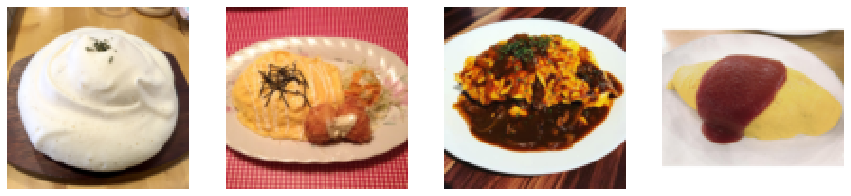

In [0]:
plt.figure(figsize=(15,15))

plt.subplot(1, 4, 1)
#plt.title('sample 1',fontsize=30)
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.grid(False)
plt.imshow((imgs[0].numpy().transpose(1,2,0)*255.))

plt.subplot(1, 4, 2)
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.grid(False)
plt.imshow((imgs[1].numpy().transpose(1,2,0)*255.))

plt.subplot(1, 4, 3)
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.grid(False)
plt.imshow((imgs[2].numpy().transpose(1,2,0)*255.))

plt.subplot(1, 4, 4)
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.grid(False)
plt.imshow((imgs[3].numpy().transpose(1,2,0)*255.))

plt.show()

In [0]:
gan = GAN(n_channel=3)